# EDA

In [1]:
import imageio.v3 as iio
import numpy as np
import os
import matplotlib.pyplot as plt

### Load the images

In [6]:
# absolute paths make debuggin easier
input_dir = "/Users/pschafer/Projects/misty_pathoplex/dkd_data/images_clustered_uncolored"

In [7]:
images = {}
for file in os.scandir(input_dir):
    im = iio.imread(f"{input_dir}/{file.name}")
    images[file.name] = im

Actually we only have 422 and not 423 images

In [8]:
len(images)

422

Look at the first image.

In [9]:
list(images.values())[0]

array([[25, 25, 25, ...,  2, 31, 31],
       [25, 25, 25, ...,  2,  2, 31],
       [25, 25, 25, ...,  2,  2, 31],
       ...,
       [ 0,  0, 20, ..., 11, 11, 11],
       [ 0,  0, 20, ..., 40,  2, 11],
       [ 0,  0, 20, ..., 14, 24, 38]], dtype=uint8)

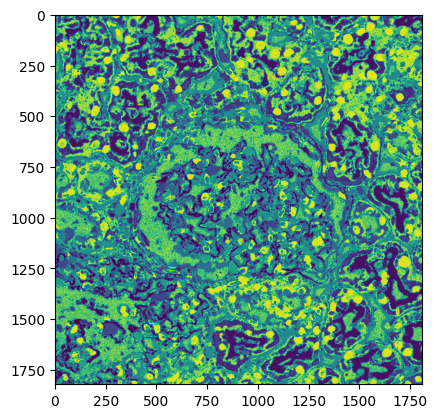

In [10]:
plt.imshow(list(images.values())[0])
plt.show()

Note that the images have different sizes due to image registering: "we just cut them to exact overlap of all cycles but the size of any given pixel is constant throughout the dataset".

In [17]:
for i in range(10):
    print(list(images.values())[i].shape)

(1821, 1810)
(1824, 1817)
(1741, 1732)
(1736, 1748)
(1817, 1824)
(1801, 1802)
(1843, 1821)
(1862, 1830)
(1819, 1848)
(1843, 1785)


How many unique cell types do we have?

In [18]:
cluster_types = []
for image in images.values():
    cluster_types.append(np.unique(image))
cluster_types = np.unique(np.array(cluster_types))
len(cluster_types)

47

In [19]:
cluster_types

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=uint8)

Check whether the clusters are labeled 1 to number of clusters

In [20]:
all(cluster_types == list(range(len(cluster_types))))

True

The pixel have a side length of 162.4 nm. 

We will aggregate the information to squares with 10 μm = 10,000 nm. This means we will create bins of size `p_size` x `p_size`

This is in the same order of magnitude as the diameter of many human cell types (just note that FFPE tissue is shrunken to some extend) 

In [21]:
p_size = int(np.ceil(10_000 / 162.4))
p_size

62

### Workflow Single Image

In [22]:
img = list(images.values())[0]
img

array([[25, 25, 25, ...,  2, 31, 31],
       [25, 25, 25, ...,  2,  2, 31],
       [25, 25, 25, ...,  2,  2, 31],
       ...,
       [ 0,  0, 20, ..., 11, 11, 11],
       [ 0,  0, 20, ..., 40,  2, 11],
       [ 0,  0, 20, ..., 14, 24, 38]], dtype=uint8)

First we define how many bins fit in the rows and the columns of a given image, and thus how many bins (aka spots) we will have in the end. 

Then we initialize the matrices to store the coordinates and the number of cluster instances in each bin.

In [23]:
nrows = int(np.ceil(img.shape[0] / p_size))
ncols = int(np.ceil(img.shape[1] / p_size))
n_spots = nrows * ncols

coords = np.zeros((n_spots, 2)).astype(int)
cluster_counts = np.zeros((n_spots, len(cluster_types))).astype(int)

Looking at the bin in the first row and column

In [24]:
i, j = 0, 0

Looking at the coordinates.

In [25]:
coords[ (i*ncols) + j, : ] = np.array([ (i+1)*(p_size/2), (j+1)*(p_size/2) ])
coords[ (i*ncols) + j, : ] 

array([31, 31])

Looking at the cluster counts.

In [26]:
counts_i  = np.unique(img[i*p_size:(i+1)*p_size, j*p_size:(j+1)*p_size].flatten(), return_counts=True)
counts_i

(array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 16, 20, 22, 23, 24, 25,
        27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 46],
       dtype=uint8),
 array([   1,  456,  141,   17,  884,    3,  250,  143,   13,    1,    3,
           4,    5,   28,   11,   17,   91,   15,  326,   17,   18,   12,
          34,    3,   36,   41,   13,    1, 1016,  175,    7,   15,   47]))

Check whether the total number of counts is correct.

In [27]:
p_size**2 == sum(counts_i[1])

True

So here we have no counts for clusters:

In [28]:
cluster_types[~np.isin(cluster_types, counts_i[0])]

array([ 1, 10, 11, 14, 15, 17, 18, 19, 21, 26, 32, 37, 41, 44],
      dtype=uint8)

Adding the counts to the cluster counts matrix.

In [29]:
cluster_counts[(i*ncols) + j, counts_i[0]] = counts_i[1]
cluster_counts[(i*ncols) + j, :]

array([   1,    0,  456,  141,   17,  884,    3,  250,  143,   13,    0,
          0,    1,    3,    0,    0,    4,    0,    0,    0,    5,    0,
         28,   11,   17,   91,    0,   15,  326,   17,   18,   12,    0,
         34,    3,   36,   41,    0,   13,    1, 1016,    0,  175,    7,
          0,   15,   47])

Now, we loop through all the bins (over all rows `i`, over all cols `j`).

In [30]:
for i in range(nrows):
    for j in range(ncols):
        # bin number
        bin_num = (i*ncols) + j

        # take care of coordinates
        coords[ bin_num, : ] = np.array([ (p_size/2) + i*p_size, (p_size/2) + j*p_size ])
    
        # take care of cluster counts
        xmin, xmax = i*p_size, (i+1)*p_size
        ymin, ymax = j*p_size, (j+1)*p_size

        # take care of edge cases
        xmax = min(xmax, img.shape[0])
        ymax = min(ymax, img.shape[1])

        # count the cluster instances
        counts_i  = np.unique(img[xmin:xmax, ymin:ymax].flatten(), return_counts=True)
        cluster_counts[bin_num, counts_i[0]] = counts_i[1]

### Workflow All Images

Now the same but also looping over all images.

In [31]:
coords_imgs = {}
cluster_counts_imgs = {}

for k, im in images.items():
    nrows = int(np.ceil(im.shape[0] / p_size))
    ncols = int(np.ceil(im.shape[1] / p_size))
    n_spots = nrows * ncols

    coords = np.zeros((n_spots, 2)).astype(int)
    cluster_counts = np.zeros((n_spots, len(cluster_types))).astype(int)

    for i in range(nrows):
        for j in range(ncols):
            # bin number
            bin_num = (i*ncols) + j

            # take care of coordinates
            coords[ bin_num, : ] = np.array([ (p_size/2) + i*p_size, (p_size/2) + j*p_size ])
        
            # take care of cluster counts
            xmin, xmax = i*p_size, (i+1)*p_size
            ymin, ymax = j*p_size, (j+1)*p_size

            # take care of edge cases
            xmax = min(xmax, im.shape[0])
            ymax = min(ymax, im.shape[1])

            # count the cluster instances
            counts_i  = np.unique(im[xmin:xmax, ymin:ymax].flatten(), return_counts=True)
            cluster_counts[bin_num, counts_i[0]] = counts_i[1]

    coords_imgs[k] = coords
    cluster_counts_imgs[k] = cluster_counts
